In [1]:
import os
import datetime
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.signal import stft
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as colors

from ai import cdas
import soundfile as sf
from sonificationMethods.paulstretch_mono import paulstretch

In [2]:
#load magnetic field data from CDAWeb
def load_thm_fgm(start_time,end_time,probe='thd',product='fgs',coord='gsm'):
    fgm = cdas.get_data('sp_phys',probe.upper()+'_L2_FGM',
                            start_time,end_time,[probe+'_'+product+'_'+coord])
    return fgm


#load state/ephemeris data from CDAWeb
def load_thm_state(start_time,end_time,probe='thd',coord='gsm'):
    state_gsm = cdas.get_data('sp_phys',probe.upper()+'_OR_SSC',
                              start_time,end_time,['XYZ_'+coord.upper()])
    return state_gsm

#load electron moments data from CDAWeb
def load_thm_mom(start_time,end_time,probe='thd',coord='gsm'):
    peem = cdas.get_data('sp_phys',probe.upper()+'_L2_MOM',start_time,end_time,
                         [probe+'_peem_density',probe+'_peem_velocity_'+coord,probe+'_peem_flux'])
    return peem

#Find neighbor values of a list
def find_neighbors(data,num=3):
    #data is a 1-D list with Tures and Falses, the Tures are the data points that need to be updated
    #num is the number of neighboring data points on either side of the data point that needs to be updated
    updated_data = data.copy() 
    len_arr = len(data)
    for ind, TF in enumerate(data):
            if TF:
                min_ind = max(0,ind-num) #lower boundary cannot be lower than 0
                max_ind = min(ind+num,len_arr) #upper boundary cannot be larger than the length of the array
                updated_data[min_ind:max_ind] = True
    return updated_data

#apply paulstretch to a time series 
def thm_fgm_paulstretch(times,data,stretch=8,window=512./44100,samplerate=44100,return_time=False):
# Window for paulstretch is specifed so as to be equivalent to a window of 512 samples when using 
# the default sample rate of 44100
    paulStretch_data = paulstretch(data,stretch,window,samplerate=samplerate)
    
    if return_time == False:
        return paulStretch_data
    else:
        epochs = [ii.timestamp() for ii in times]
        epoch_stretch = np.linspace(epochs[0],epochs[-1],int(len(times) * stretch))
        epoch_stretch = epoch_stretch[:len(paulStretch_data)]
        times_interp_dt = np.array([datetime.datetime.fromtimestamp(ii) for ii in epoch_stretch])
        return times_interp_dt,paulStretch_data
    
def fac_transformation(mag_field, mean_field, pos_gsm):
    """
    Transfer to mean field coordinate
    from an input B vector array, mean field array, and a position vector array
    Inputs
    ----------
        mag_field: the B-field data to be transfered into FAC (N*3 2D array)
        mean_field: the mean B-field data, should have the same shape as mag_field 
        pos_gsm: spacecraft position data in GSM coord, should have the same shape as mag_field 
    Returns
    ----------
        The FAC transformation B vector: [pol, tor, com] or [radial,azimuthal,field-aligned]
    """   
    #make mean_field unit vector
    B_mean_amp = mean_field[:,0] ** 2 + mean_field[:,1] ** 2 + mean_field[:,2]**2
    B_mean_amp = B_mean_amp ** (1/2)
    #unit vector in mean field direction
    Uz = mean_field/np.stack((B_mean_amp,B_mean_amp,B_mean_amp),axis=-1)
    
    #unit vector in azimuthal direction
    Uy = np.cross(mean_field,pos_gsm)
    Uy_amp = Uy[:,0] ** 2 + Uy[:,1] ** 2 + Uy[:,2]**2
    Uy_amp = Uy_amp ** (1/2)
    Uy = Uy/np.stack((Uy_amp,Uy_amp,Uy_amp),axis=-1) 
    
    #unit vector in radial direction
    Ux = np.cross(Uy,Uz)
    
    #rotate mag_field in the FAC coord
    fac_field = mag_field.copy()
    fac_field[:,0] = mag_field[:,0]*Ux[:,0] + mag_field[:,1]*Ux[:,1] + mag_field[:,2]*Ux[:,2]
    fac_field[:,1] = mag_field[:,0]*Uy[:,0] + mag_field[:,1]*Uy[:,1] + mag_field[:,2]*Uy[:,2]
    fac_field[:,2] = mag_field[:,0]*Uz[:,0] + mag_field[:,1]*Uz[:,1] + mag_field[:,2]*Uz[:,2]
    
    return fac_field

In [34]:
#load magnetic field data from CDAWeb
start_time = datetime.datetime(2008, 11, 11,16)
end_time = datetime.datetime(2008, 11, 14,16)
probe='the'

start_time = datetime.datetime(2008, 12, 7)
end_time = datetime.datetime(2008, 12, 10)
probe='thd'

fgs_gsm = load_thm_fgm(start_time,end_time,probe=probe,product='fgs',coord='gsm')
fgs_gsm_Bx = fgs_gsm['BX_FGS-D']
fgs_gsm_By = fgs_gsm['BY_FGS-D']
fgs_gsm_Bz = fgs_gsm['BZ_FGS-D']
fgs_gsm_time = fgs_gsm['UT']

In [35]:
#interpolate the magnetic field data to a consistent 3 sec resolution
fgs_gsm_epoch = [ii.timestamp() for ii in fgs_gsm_time]
spacing = 3.
num = int((fgs_gsm_epoch[-1] - fgs_gsm_epoch[0])/spacing)
fgs_gsm_epoch_itp = fgs_gsm_epoch[0] + np.arange(0,num+1) * spacing

fx0 = interpolate.interp1d(fgs_gsm_epoch, fgs_gsm_Bx, kind='linear',fill_value="extrapolate")
fy0 = interpolate.interp1d(fgs_gsm_epoch, fgs_gsm_By, kind='linear',fill_value="extrapolate")
fz0 = interpolate.interp1d(fgs_gsm_epoch, fgs_gsm_Bz, kind='linear',fill_value="extrapolate")

fgs_gsm_Bx_itp = fx0(fgs_gsm_epoch_itp)
fgs_gsm_By_itp = fy0(fgs_gsm_epoch_itp)
fgs_gsm_Bz_itp = fz0(fgs_gsm_epoch_itp)

fgs_gsm_time_itp = np.array([datetime.datetime.fromtimestamp(ii) for ii in fgs_gsm_epoch_itp])

In [36]:
#load state/ephemeris data from CDAWeb
state_gsm = load_thm_state(start_time,end_time,probe=probe,coord='gsm')
pos_x = state_gsm['X'] #unit in Earth radii
pos_y = state_gsm['Y']
pos_z = state_gsm['Z']
pos_time = state_gsm['EPOCH']

In [38]:
#save position file (no interpolation)
start_time_plot = start_time #datetime.datetime(2008, 11, 11,16)
end_time_plot = end_time # datetime.datetime(2008, 11, 14,16)
time_index = (pos_time >= start_time_plot) & (pos_time <= end_time_plot)
st_str = start_time_plot.strftime("%Y%m%d")
et_str = end_time_plot.strftime("%Y%m%d")

d = {'datetime':pos_time[time_index],
     'GSM_X_RE':pos_x[time_index],
     'GSM_Y_RE':pos_y[time_index],
     'GSM_Z_RE':pos_z[time_index]}
pos_df = pd.DataFrame(data=d)
df_round2 = pos_df.round({'GSM_X_RE': 2, 'GSM_Y_RE': 2, 'GSM_Z_RE': 2})
print(df_round2)
filename = 'text_output/'+probe.upper()+'_GSMpositions_'+st_str+'_'+et_str+'.txt'
df_round2.to_csv(filename,index=False)

                datetime  GSM_X_RE  GSM_Y_RE  GSM_Z_RE
0    2008-12-07 00:00:00      2.88     -0.31      1.09
1    2008-12-07 00:01:00      2.85     -0.27      1.09
2    2008-12-07 00:02:00      2.82     -0.22      1.09
3    2008-12-07 00:03:00      2.78     -0.18      1.09
4    2008-12-07 00:04:00      2.75     -0.14      1.09
...                  ...       ...       ...       ...
4316 2008-12-09 23:56:00      2.66     -0.17      1.07
4317 2008-12-09 23:57:00      2.63     -0.12      1.07
4318 2008-12-09 23:58:00      2.59     -0.08      1.07
4319 2008-12-09 23:59:00      2.56     -0.03      1.07
4320 2008-12-10 00:00:00      2.53      0.01      1.07

[4321 rows x 4 columns]


In [39]:
#interpolate position data to the fgs time stamps
pos_epoch = [ii.timestamp() for ii in pos_time]
fx = interpolate.interp1d(pos_epoch, pos_x, kind='linear',fill_value="extrapolate")
fy = interpolate.interp1d(pos_epoch, pos_y, kind='linear',fill_value="extrapolate")
fz = interpolate.interp1d(pos_epoch, pos_z, kind='linear',fill_value="extrapolate")

interp_pos_x = fx(fgs_gsm_epoch_itp)
interp_pos_y = fy(fgs_gsm_epoch_itp)
interp_pos_z = fz(fgs_gsm_epoch_itp)

pos_r = np.sqrt(interp_pos_x**2+interp_pos_y**2+interp_pos_z**2)

In [40]:
#load electron moments data from CDAWeb for magnetosheath interval identification
peem = load_thm_mom(start_time,end_time,probe=probe,coord='gsm')
peem_time = peem['UT']
density=peem['N_ELEC_MOM_ESA-'+probe[2].upper()]
velocity_x=peem['VX_ELEC_GSM_MOM_ESA-'+probe[2].upper()]
flux_x = peem['FX_ELEC_MOM_ESA-'+probe[2].upper()] 
flux_y = peem['FY_ELEC_MOM_ESA-'+probe[2].upper()]

In [41]:
#interpolate ESA data to the fgs time stamps
peem_epoch = [ii.timestamp() for ii in peem_time]
fx1 = interpolate.interp1d(peem_epoch, density, kind='linear', fill_value="extrapolate")
interp_density = fx1(fgs_gsm_epoch_itp)

fx2 = interpolate.interp1d(peem_epoch, velocity_x, kind='linear',fill_value="extrapolate")
interp_velocity = fx2(fgs_gsm_epoch_itp)

fx3 = interpolate.interp1d(peem_epoch, flux_x, kind='linear',fill_value="extrapolate")
fy3 = interpolate.interp1d(peem_epoch, flux_y, kind='linear',fill_value="extrapolate")
interp_flux_x = fx3(fgs_gsm_epoch_itp)
interp_flux_y = fy3(fgs_gsm_epoch_itp)
flux_perp = np.sqrt(interp_flux_x**2+interp_flux_y**2)

In [42]:
#remove periods when spacecraft is in the magnetosheath
#magnetosheath is when r>8 AND either (1) density is above 10/CC or (2) perp flux>2e7 or (3) tailward velocity>200km/s
sheath_flag = (pos_r > 8) & ((interp_density > 10) | (interp_velocity < -200) | (flux_perp > 2e7))

#remove magnetosheath data points that are 9 sec on either side of the centered data point
sheath_flag_update = find_neighbors(sheath_flag,num=3)
print(sum(sheath_flag_update)) #number of Trues in the list
print(sum(sheath_flag))

1123
313


In [43]:
#Linear interpolation to fill “NAN” gaps in the magnetic field time series due to magnetosheath flags
Bx_no_ms = fgs_gsm_Bx_itp[~sheath_flag_update]
By_no_ms = fgs_gsm_By_itp[~sheath_flag_update]
Bz_no_ms = fgs_gsm_Bz_itp[~sheath_flag_update]
epoch_no_ms = fgs_gsm_epoch_itp[~sheath_flag_update]

fx4 = interpolate.interp1d(epoch_no_ms, Bx_no_ms, kind='linear',fill_value="extrapolate")
fy4 = interpolate.interp1d(epoch_no_ms, By_no_ms, kind='linear',fill_value="extrapolate")
fz4 = interpolate.interp1d(epoch_no_ms, Bz_no_ms, kind='linear',fill_value="extrapolate")

Bx_itp = fx0(fgs_gsm_epoch_itp)
By_itp = fy0(fgs_gsm_epoch_itp)
Bz_itp = fz0(fgs_gsm_epoch_itp)

In [44]:
#Convert mag data to a pandas dataframe and do running acerage detrend
Bint = np.stack((Bx_itp,By_itp,Bz_itp),axis=-1)
df = pd.DataFrame(Bint, columns = ['Bx_gsm', 'By_gsm','Bz_gsm'])
df['datetime']=fgs_gsm_time_itp
print(df)

#Detrending by substracting 30-min running average
#This will result in nan at the edges, we will replace nan with zeros in the end
Bx_SMA = df.iloc[:,0].rolling(window=600, center=True).mean()
detrend_Bx = Bx_itp - Bx_SMA

By_SMA = df.iloc[:,1].rolling(window=600, center=True).mean()
detrend_By = By_itp - By_SMA

Bz_SMA = df.iloc[:,2].rolling(window=600, center=True).mean()
detrend_Bz = Bz_itp - Bz_SMA

           Bx_gsm     By_gsm       Bz_gsm                datetime
0     -156.718000 -42.081000  1065.910000 2008-12-07 00:00:01.622
1     -156.596298 -42.030835  1067.413958 2008-12-07 00:00:04.622
2     -157.119859 -41.606300  1068.967367 2008-12-07 00:00:07.622
3     -158.289909 -40.807091  1070.560069 2008-12-07 00:00:10.622
4     -159.204934 -40.998983  1072.153094 2008-12-07 00:00:13.622
...           ...        ...          ...                     ...
86394 -357.503837  -9.969890  1479.832678 2008-12-09 23:59:43.622
86395 -357.800222  -9.931695  1482.130534 2008-12-09 23:59:46.622
86396 -360.511889  -9.750380  1484.635303 2008-12-09 23:59:49.622
86397 -360.644076  -9.552784  1486.919713 2008-12-09 23:59:52.622
86398 -362.846803  -8.357645  1489.384716 2008-12-09 23:59:55.622

[86399 rows x 4 columns]


In [47]:
#Rotate detrend B into field-aligned coordinates
pos_gsm = np.stack((interp_pos_x,interp_pos_y,interp_pos_z),axis=-1)
mag_field = np.stack((detrend_Bx,detrend_By,detrend_Bz),axis=-1)
mean_field = np.stack((Bx_SMA,By_SMA,Bz_SMA),axis=-1)
B_fac = fac_transformation(mag_field, mean_field, pos_gsm)

dB_phi = B_fac[:,1]

In [63]:
print(mag_field[5000:5010,1])
print(B_fac[5000:5010,1])

[0.8604563  0.74605731 0.71631807 0.86038615 0.92088252 0.87808644
 0.80647572 0.81446606 0.8147182  0.81765558]
[-1.3960834  -1.28196437 -1.27392433 -1.37514915 -1.50523343 -1.48701117
 -1.41390471 -1.41912621 -1.43993467 -1.45538248]


In [48]:
#replace periods when spacecraft position is at r<5 Re with zeros
r_flag = pos_r < 5
dB_phi_zero = dB_phi.copy()
dB_phi_zero[r_flag] = 0

#replace any nan values with zeros
dB_phi_zero = np.nan_to_num(dB_phi_zero)

In [62]:
print(dB_phi_zero[5000:5010])
print(dB_phi[5000:5010])

[-1.3960834  -1.28196437 -1.27392433 -1.37514915 -1.50523343 -1.48701117
 -1.41390471 -1.41912621 -1.43993467 -1.45538248]
[-1.3960834  -1.28196437 -1.27392433 -1.37514915 -1.50523343 -1.48701117
 -1.41390471 -1.41912621 -1.43993467 -1.45538248]


In [49]:
#paulstretch
window=512./44100 #~0.0116

#3-days, factor=6
stretch=6
#start_time_plot = datetime.datetime(2008, 11, 11,16)
#end_time_plot = datetime.datetime(2008, 11, 14,16)


time_index = (fgs_gsm_time_itp >= start_time_plot) & (fgs_gsm_time_itp <= end_time_plot)
times = fgs_gsm_time_itp[time_index]
dB_phi_data = dB_phi_zero[time_index]

samplerate = 44100
paulStretch_dB_phi_zero = thm_fgm_paulstretch(times,dB_phi_data,samplerate=samplerate,
                                              stretch=stretch,window=window,return_time=False)

#calculate dB/dt after time stretch and save to ogg file
stretch_spacing = spacing/stretch
print(stretch_spacing)
dB_phi_dt_aft_stretch = np.diff(paulStretch_dB_phi_zero)/stretch_spacing

#paulStretch_detrend_Bx_nan[r_flag] = 0 
#paulStretch_detrend_Bx_nan[sheath_flag] = 0
samplerate = 44100
sf.write('sound_output/'+probe.upper()+'_dBphidt_'+
         start_time_plot.strftime("%Y%m%d")+'_'+
         end_time_plot.strftime("%Y%m%d")+'_paulstretch'+
         str(stretch)+'_final.wav', dB_phi_dt_aft_stretch, samplerate)

sf.write('sound_output/'+probe.upper()+'_dBphidt_'+
         start_time_plot.strftime("%Y%m%d")+'_'+
         end_time_plot.strftime("%Y%m%d")+'_paulstretch'+
         str(stretch)+'_final.ogg', dB_phi_dt_aft_stretch, samplerate)

0.5


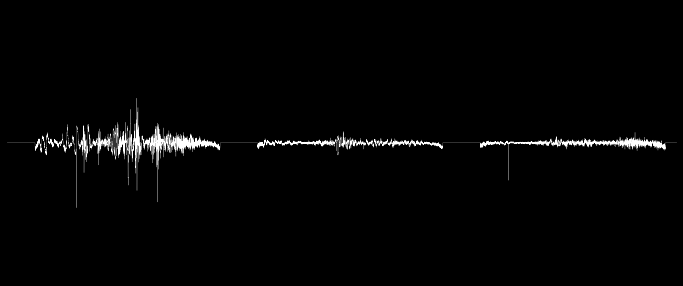

In [50]:
#Plot detrended B_phi time series
%matplotlib inline
#%matplotlib notebook
fig, ax1 = plt.subplots(1,1,figsize=(12,5))
plt.axis('off')

#start_time_plot = datetime.datetime(2008, 11, 11,16)
#end_time_plot = datetime.datetime(2008, 11, 14,16)

ax1.margins(0,0)

xlim=[start_time_plot,end_time_plot]
ylim=[-20,20]

fig.patch.set_facecolor('k')
ax1.plot(fgs_gsm_time_itp,dB_phi_zero,c='w', linewidth=0.2)
ax1.set(xlim=xlim,ylim=ylim)

fn = Path('image_output/'+probe.upper()+'_detrend_Bphi_ts_'+
          start_time_plot.strftime("%Y%m%d")+'_'+
          end_time_plot.strftime("%Y%m%d")+'_final.png').expanduser()
fig.savefig(fn, dpi = 600, bbox_inches='tight',pad_inches = 0)

0.022000672414197526
0.022000672414197526


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("inferno"))
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


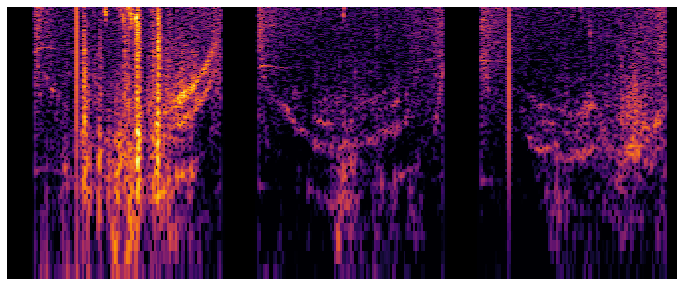

In [68]:
#Plot dB_phi/dt spectra
%matplotlib inline
fig, ax2 = plt.subplots(1,1,figsize=(12,5))
plt.axis('off')
ax2.margins(0,0)

#start_time_plot = datetime.datetime(2008, 11, 11,16)
#end_time_plot = datetime.datetime(2008, 11, 14,16)

time_index = (fgs_gsm_time_itp >= start_time_plot) & (fgs_gsm_time_itp <= end_time_plot)
dB_phi_ti = dB_phi_zero[time_index]

#calculate dB/dt
spacing = 3.
dB_phi_dt = np.diff(dB_phi_ti)/spacing

xlim=[start_time_plot,end_time_plot]

#Compute the Short Time Fourier Transform (STFT)
f, t, Zxx = stft(dB_phi_dt, fs=1/3.0, nperseg=1024,noverlap=768)
dt_list = [start_time+datetime.timedelta(seconds=ii) for ii in t]

mag = np.abs(Zxx)
print(np.amax(mag))

mag_2mHz = mag[7:,:]
max_mag_2mHz = np.amax(mag_2mHz)
print(max_mag_2mHz)

#set bad data 0 (i.e., data gap) to black
mag = np.ma.masked_where(mag == 0.0, mag)
cmap=plt.get_cmap('inferno')#
cmap.set_bad(color='black')

im=ax2.pcolormesh(dt_list, f*1000., mag/max_mag_2mHz,cmap=cmap, norm=colors.LogNorm(vmin=0.01, vmax=1.))#
ax2.set(xlim=xlim,ylim=[1,100])
ax2.set_yscale('log')

fn = Path('image_output/'+probe.upper()+'_dBphidt_stft_Ylog_'+
          start_time_plot.strftime("%Y%m%d")+'_'+end_time_plot.strftime("%Y%m%d")+
          '_final.png').expanduser()
fig.savefig(fn, dpi = 600, bbox_inches='tight',pad_inches = 0)